In [1]:
%pylab inline
import magproc.magdata
import magproc.pipeline
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
d = magproc.magdata.MagData.load("../2025-07-14 mag_qc_dev/data/full_test_data.fixed.csv")

In [3]:
d

filename: full_test_data.fixed.csv
sample_frequency: 40.000000009313226


                       count           mean           std            min            25%            50%            75%            max
Unnamed: 0  247882.0  123940.500000  71557.514051       0.000000   61970.250000  123940.500000  185910.750000  247881.000000
Date        247882.0    2023.721256      0.006817    2023.715068    2023.715068    2023.715068    2023.728767    2023.728767
DEMIFSAR    247882.0     407.587466    162.649756     120.280000     304.120000     372.190000     479.810000    1330.590000
Diurnal     247882.0   55152.701387     28.575697   55091.730100   55129.778175   55156.863450   55164.836275   55203.807500
Easting     247882.0  698616.594751  32364.958619  639935.791000  670702.319250  701934.340500  724031.041500  759139.396000
GPSALT      247882.0     613.357737    209.974463     262.340000     472.400000     567.150000     694.477500    1599.090000
MAGUNCOM    247882.0   55501.915134     62.

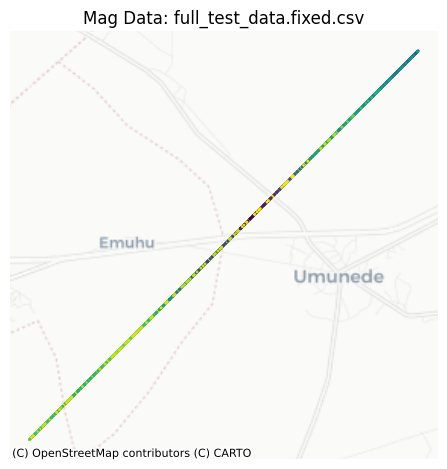

<Axes: title={'center': 'Mag Data: full_test_data.fixed.csv'}>

In [4]:
d.plot_map(markersize=1, zoom=12, column="MAGCOM")

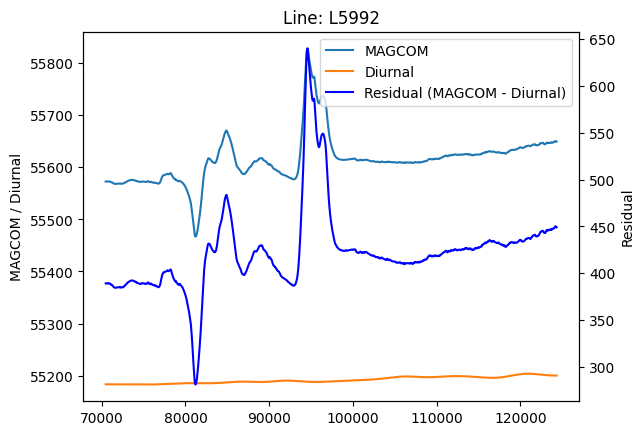

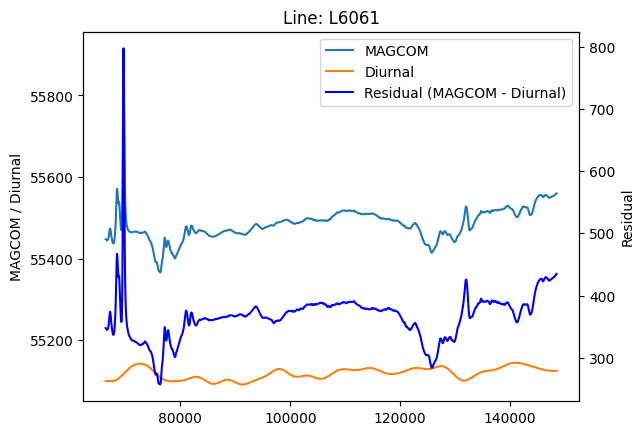

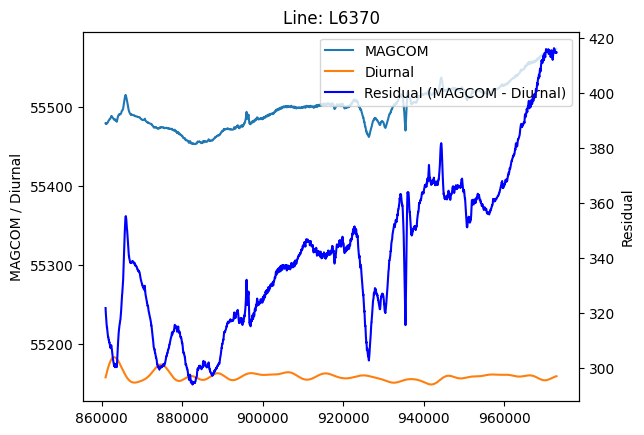

In [5]:
d.plot()

In [6]:
d.save("foo.mag.zip")

In [11]:
p = magproc.pipeline.MagPipeline.parse("""
steps:
 - set_meta:
     crs: 32604
     diurnal:
       lat: 62.9588417 
       lon: -155.599325 
 - set_constants
 - lowpass_filter_butterworth:
     cutoff_freq: 0.01 # Hz, note max at the nyquist freq at sample rate 40Hz / 2
 - diurnal_qc_for_15s_chord
 - diurnal_qc_for_60s_chord
 - drape_and_speed_qc
 - noice_qc:
     MAG_4th_diff_OOS_threshold: 0.05
 - write_noise_summary
 - write_diurnal_summary
 - write_drape_summary
""", out_path="../testout")


In [12]:
os.makedirs(p.pipeline["out_path"], exist_ok=True)
dp = p.run(d)

Running step 0: set_meta with crs=32604, diurnal={'lat': 62.9588417, 'lon': -155.599325}
Running step 1: set_constants
Running step 2: lowpass_filter_butterworth with cutoff_freq=0.01
Running step 3: diurnal_qc_for_15s_chord
Running step 4: diurnal_qc_for_60s_chord
Running step 5: drape_and_speed_qc
Running step 6: noice_qc with MAG_4th_diff_OOS_threshold=0.05
Running step 7: write_noise_summary
Running step 8: write_diurnal_summary
Running step 9: write_drape_summary


/home/redhog/Projects/AGF-GeoPhysics/OM_DGGS_python_extensions/magproc/magfilters.py:415: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  drape_summary = pd.concat([drape_summary, OOS_drape], ignore_index=True) # add OOS drape segments to summary dataframe


In [13]:
dp

crs: 32604
diurnal:
  lat: 62.9588417
  lon: -155.599325
filename: full_test_data.fixed.csv
sample_frequency: 40.000000009313226


                                     count          mean           std            min            25%            50%            75%            max
Unnamed: 0                247882.0  1.239405e+05  7.155751e+04       0.000000   61970.250000  123940.500000  185910.750000  247881.000000
Date                      247882.0  2.023721e+03  6.817273e-03    2023.715068    2023.715068    2023.715068    2023.728767    2023.728767
DEMIFSAR                  247882.0  4.075875e+02  1.626498e+02     120.280000     304.120000     372.190000     479.810000    1330.590000
Diurnal                   247882.0  5.515270e+04  2.857570e+01   55091.730100   55129.778175   55156.863450   55164.836275   55203.807500
Easting                   247882.0  6.986166e+05  3.236496e+04  639935.791000  670702.319250  701934.340500  724031.041500  759139.396000
GPSALT                    247882.

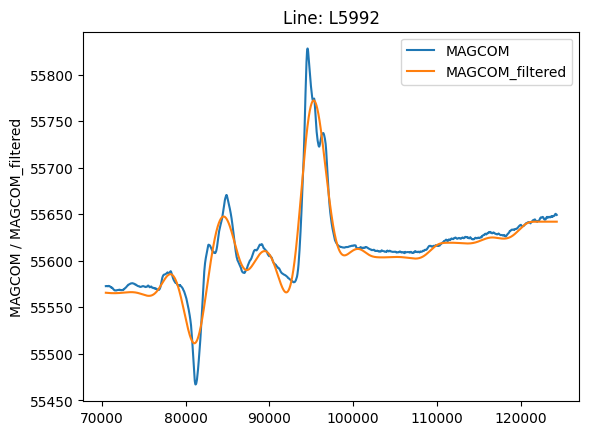

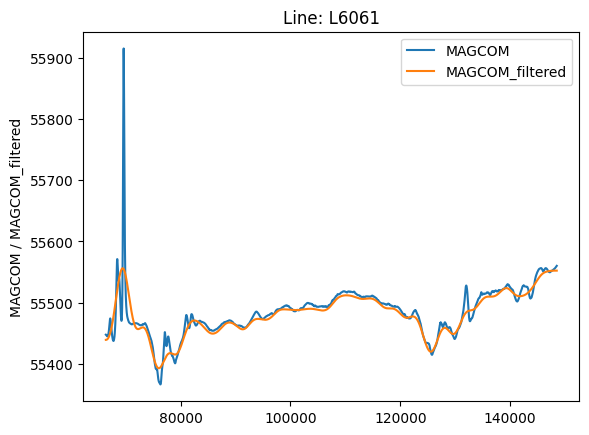

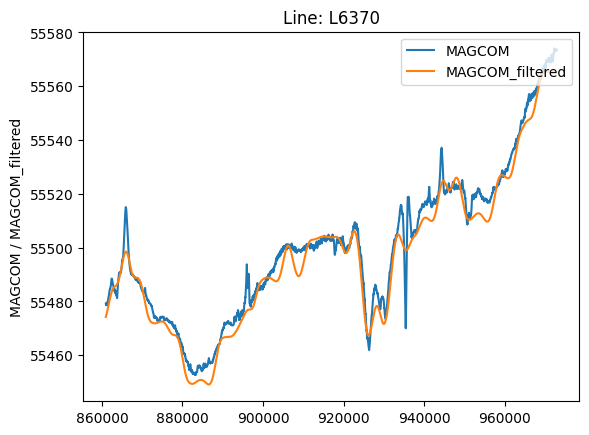

In [14]:
dp.plot(columns=["MAGCOM", "MAGCOM_filtered"])